In [287]:
import numpy as np
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,summarize)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from ISLP import confusion_table
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Modified Problem 1

In [282]:
np.random.seed(1)
x_11 = np.random.normal(1, 1, 200)
x_21 = np.random.normal(0, 1, 200)
x_12 = np.random.normal(-1, 1, 200)
x_22 = np.random.normal(0, 1, 200)
x_1 = np.concatenate((x_11, x_12))
x_2 = np.concatenate((x_21, x_22))
xs = np.matrix([x_1, x_2]).T
probs = (np.exp(5*xs[:,0]-1*xs[:,1]))/(1+np.exp(5*xs[:,0]-1*xs[:,1]))
y = []
for i in range(len(probs)):
    val = np.random.binomial(1, p=probs[i,0])
    y.append(val)
y = np.matrix(y).T
xs = np.append(xs, y, 1)

#### (a)

In [283]:
x = xs[:,:-1]
y = xs[:,-1]
beta_old = np.matrix([[0], [0]])
beta_new = np.matrix([[1], [1]])
lr = 0.1
count = 0
while np.sum(abs(beta_new - beta_old)) > 0.0001:
    if count != 0:
        beta_old = beta_new
    preds = (np.exp(np.dot(x, beta_old)))/(1+np.exp(np.dot(x, beta_old)))
    beta_new = beta_old + lr*(np.dot(x.T, y) - np.dot(x.T, preds))
    count += 1
print(beta_new)

[[ 4.97700994]
 [-0.98286889]]


In [284]:
glm = sm.GLM(y, x, family=sm.families.Binomial()) 
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
x1,4.9768,0.626,7.946,0.0
x2,-0.9828,0.251,-3.918,0.0


#### (b)

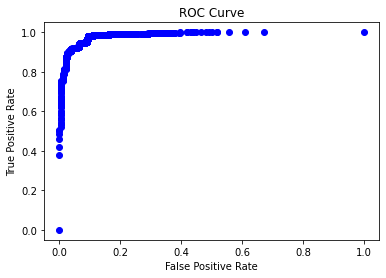

0.08994708994708994
0.03317535545023697


In [285]:
y_true = xs[:,-1]
y_prob = (np.exp(np.dot(x, beta_new)))/(1+np.exp(np.dot(x, beta_new)))
roc = pd.DataFrame()
intv = np.arange(0, 1.001, 0.001)
roc['threshold'] = []
roc['FPR'] = []
roc['TPR'] = []
for thresh in intv:
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    y_pred = []
    for i in range(len(y_prob)):
        if y_prob[i,0] >= thresh:
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred = np.matrix(y_pred).T
    for j in range(len(y_true)):
        if y_true[j,0] == 1:
            if y_pred[j,0] == 1:
                tp += 1
            else:
                fn += 1
        if y_true[j,0] == 0:
            if y_pred[j,0] == 0:
                tn += 1
            else:
                fp += 1
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    roc.loc[len(roc.index)] = [thresh, fpr, tpr]
plt.plot(roc['FPR'], roc['TPR'], 'bo')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
tp = 0
fn = 0
fp = 0
tn = 0
y_pred = []
for i in range(len(y_prob)):
    if y_prob[i,0] >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred = np.matrix(y_pred).T
for j in range(len(y_true)):
    if y_true[j,0] == 1:
        if y_pred[j,0] == 1:
            tp += 1
        else:
            fn += 1
    if y_true[j,0] == 0:
        if y_pred[j,0] == 0:
            tn += 1
        else:
            fp += 1
fpr = fp/(fp+tn)
fnr = fn/(fn+tp)
print(fpr)
print(fnr)

### Problem 2

0.10582010582010581
0.023696682464454975


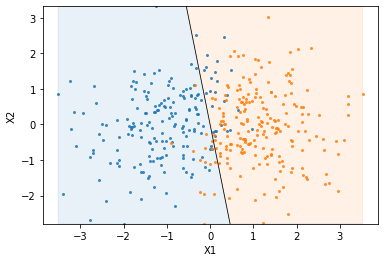

In [270]:
count = 0
for i in range(len(y_true)):
    if y_true[i,0] == 0:
        count += 1
pi_0 = count/len(y_true)
pi_1 = (len(y_true)-count)/len(y_true)
ind = np.squeeze(np.asarray(xs[:,-1])) == 0
zero = xs[ind,:]
ind = np.squeeze(np.asarray(xs[:,-1])) == 1
one = xs[ind,:]
mu_0 = np.matrix([[np.mean(zero[:,0])], [np.mean(zero[:,1])]])
mu_1 = np.matrix([[np.mean(one[:,0])], [np.mean(one[:,1])]])
x1 = np.asarray(xs[:,0]).T
x2 = np.asarray(xs[:,1]).T
covm = np.cov(x1, x2)
d_0 = np.matmul(np.matmul(x, np.linalg.inv(covm)), mu_0) - (1/2)*np.matmul((np.matmul(mu_0.transpose(), np.linalg.inv(covm))), mu_0) + np.log(pi_0)
d_1 = np.matmul(np.matmul(x, np.linalg.inv(covm)), mu_1) - (1/2)*np.matmul((np.matmul(mu_1.transpose(), np.linalg.inv(covm))), mu_1) + np.log(pi_1)
y_true = xs[:,-1]
y_preds = []
for i in range(len(d_0)):
    if d_0[i,0] > d_1[i,0]:
        y_preds.append(0)
    else:
        y_preds.append(1)
fp = 0
tn = 0
fn = 0
tp = 0
for j in range(len(y_true)):
    if y_true[j,0] == 0:
        if y_preds[j] == 0:
            tn += 1
        else:
            fp += 1
    if y_true[j,0] == 1:
            if y_preds[j] == 1:
                tp += 1
            else:
                fn += 1
fpr = fp/(fp+tn)
fnr = fn/(fn+tp)
print(fpr)
print(fnr)
data = pd.DataFrame(xs)
d_slope = np.matmul(np.linalg.inv(covm), (mu_0-mu_1))
dims = np.array([min(data[0]), max(data[0])])
bounds = np.array((d_slope[0]/d_slope[1])*dims).T
plt.plot(dims, bounds, 'k', lw = 0.75)
plt.fill_between(dims, bounds[:,0], min(data[1]), color='tab:blue', alpha=0.1)
plt.fill_between(dims, bounds[:,0], max(data[1]), color='tab:orange', alpha=0.1)
plt.ylim(min(data[1]), max(data[1]))
plt.scatter(data[data[2]==0][0], data[data[2]==0][1], s=4, alpha=0.8)
plt.scatter(data[data[2]==1][0], data[data[2]==1][1], s=4, alpha=0.8)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

### Problem 3

In [299]:
np.random.seed(1)
diabetes = pd.read_csv('/Users/zach/Jupyter/DATA 558/diabetes.csv')
x = diabetes[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = diabetes[['Outcome']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/6)

#### Logistic Regression

In [300]:
glm = sm.GLM(y_train, x_train, family=sm.families.Binomial()) 
results = glm.fit()
print(summarize(results))
probs = results.predict(exog=x_test)
labels = np.array([0]*128) 
labels[probs>0.5] = 1
accuracy_score(y_test.values.ravel(), labels)

                            coef  std err      z  P>|z|
Pregnancies               0.1226    0.031  3.918  0.000
Glucose                   0.0147    0.003  4.825  0.000
BloodPressure            -0.0308    0.005 -6.141  0.000
SkinThickness            -0.0020    0.007 -0.303  0.762
Insulin                   0.0011    0.001  1.227  0.220
BMI                      -0.0069    0.012 -0.579  0.563
DiabetesPedigreeFunction  0.2413    0.271  0.889  0.374
Age                      -0.0176    0.009 -1.905  0.057


0.6640625

In [311]:
x_train_s = x_train[['Pregnancies', 'Glucose', 'BloodPressure', 'Age']]
x_test_s = x_test[['Pregnancies', 'Glucose', 'BloodPressure', 'Age']]
glm = sm.GLM(y_train, x_train_s, family=sm.families.Binomial()) 
results = glm.fit()
probs = results.predict(exog=x_test_s)
labels = np.array([0]*128) 
labels[probs>0.5] = 1
accuracy_score(y_test.values.ravel(), labels)

0.671875

#### LDA

In [302]:
lda = LDA(store_covariance=True)
lda.fit(x_train, y_train.values.ravel())
lda_pred = lda.predict(x_test)
accuracy_score(lda_pred, y_test.values.ravel())

0.78125

In [303]:
lda = LDA(store_covariance=True)
lda.fit(x_train_s, y_train.values.ravel())
lda_pred = lda.predict(x_test_s)
accuracy_score(lda_pred, y_test.values.ravel())

0.7421875

#### Naive Bayes

In [304]:
naive = GaussianNB()
y_preds = naive.fit(x_train, y_train.values.ravel()).predict(x_test)
accuracy_score(y_preds, y_test.values.ravel())

0.7578125

In [305]:
naive = GaussianNB()
y_preds = naive.fit(x_train_s, y_train.values.ravel()).predict(x_test_s)
accuracy_score(y_preds, y_test.values.ravel())

0.7421875

#### KNN

In [297]:
nbor = KNeighborsClassifier(n_neighbors=5)
nborfit = nbor.fit(x_train, y_train.values.ravel())
y_preds = nborfit.predict(x_test)
accuracy_score(y_preds, y_test.values.ravel())

0.71875

In [309]:
nbor = KNeighborsClassifier(n_neighbors=5)
nborfit = nbor.fit(x_train_s, y_train.values.ravel())
y_preds = nborfit.predict(x_test_s)
accuracy_score(y_preds, y_test.values.ravel())

0.7421875